In [1]:
import os
import re
import sys
import glob
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.mlab as mlab

from datetime import datetime
from netCDF4 import Dataset

warnings.simplefilter("ignore")

In [2]:
def read_dataset(fd, radarName, GPM=True):
    satName = 'GPM'
    with Dataset(fd, 'r') as fid:
        ref1 = fid['ref1'][:]
        ref2 = fid['ref5'][:]
        std_sat = fid['stdv1'][:]
        std_rad = fid['stdv2'][:]
        x = fid['x'][:]
        y = fid['y'][:]
        z = fid['z'][:]
        
    df_ref = pd.DataFrame({satName: ref1, radarName: ref2})
        
    # Reflectivity difference for all samples
    pos = (ref1 >= 40) | (std_sat > 4) | (std_rad > 4) | (ref2 >= 36) | (ref1 == 0) | (ref2 < 21)
        
    ref1_clean = ref1[~pos]
    ref2_clean = ref2[~pos]    
    
    return x, y, z, ref1, ref2, ref1_clean, ref2_clean

In [11]:
data_fl = "/home/meso/dev/bonn-radar-cal/msgr_grcal_out/RID_IDR01_ORBIT_020060_DATE_20170909_PASS_2.nc"


In [19]:
titlea = ''
titleb = ''
titlec = ''
radid = 1
xl = 15
xu = 50
yl = 0.0
yup = 0.30
nbins = 66

In [25]:
x, y, z, ref1, ref2, ref1_clean, ref2_clean = read_dataset(data_fl, radid, GPM=True)
dref = ref2 - ref1

In [34]:
refl1_median = np.nanmedian(ref1)
refl2_median = np.nanmedian(ref2)

myoffset_median = refl2_median - refl1_median

print(refl1_median)
print(refl2_median)

24.956012249661143
23.52918779716188


<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence \o
<input>:18: DeprecationWarning: invalid escape sequence 

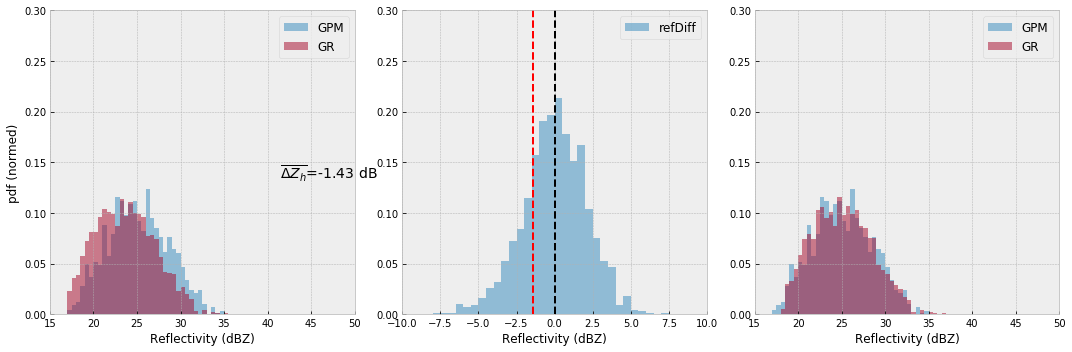

In [35]:
with pl.style.context("bmh"):
    fig, ax = pl.subplots(1, 3, figsize=(15, 5), facecolor="w")
    ax = ax.flatten()

    ax[0].hist(ref1, alpha=0.5, range=(17, xu), bins=nbins, lw=0, normed=True, label="GPM")
    ax[0].hist(ref2, alpha=0.5, range=(17, xu), bins=nbins, lw=0, normed=True, label='GR')
    #ax[0].axvline(21, color='k', linestyle=':')
    ax[0].set_xlim((xl, xu))
    ax[0].set_ylabel("pdf (normed)")
    ax[0].set_title(titlea, fontsize=12)

    ax[1].hist(dref, alpha=0.5, range=(-20, 20), bins=80, lw=0, normed=True, label="refDiff")
    ax[1].axvline(0, color='k', linestyle='--')
    ax[1].axvline(myoffset_median, color='r', linestyle='--')

    ax[1].set_xlim((-10, 10))
    ax[1].set_title(titleb, fontsize=12)
    ax[1].text(-18, 0.14, '$\overline{\Delta Z_{h}}$=%0.2f dB' % (myoffset_median), fontsize=14, va="center")

    ax[2].hist(ref1, alpha=0.5, range=(17, xu), bins=nbins, lw=0, normed=True, label="GPM")
    ax[2].hist(ref2 - myoffset_median, alpha=0.5, range=(17, xu), bins=nbins, lw=0, normed=True, label='GR')
    ax[2].set_xlim((xl, xu))
    ax[2].set_title(titlec, fontsize=12)
    
    for myax in ax:
        myax.set_ylim((yl, yup))
        myax.legend(loc=1, fontsize=12)
        myax.set_xlabel("Reflectivity (dBZ)")
            
    fig.tight_layout()
pl.savefig('corrected.png', dpi=150)
pl.show()

In [23]:
import pyart

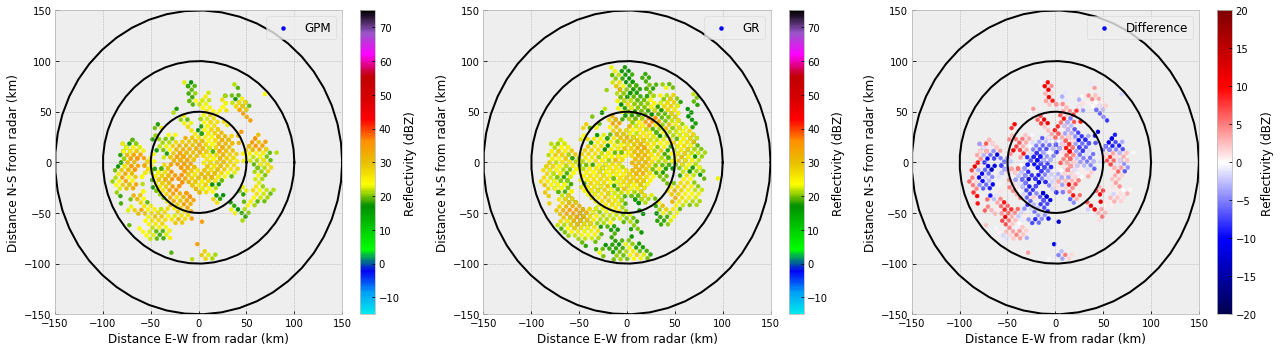

In [16]:
with pl.style.context("bmh"):
    fig, ax = pl.subplots(1, 3, figsize=(18, 5), facecolor="w")
    ax = ax.flatten()
    
    dref_bis = ref2 - ref1
    pos = (z >= 0) & (z <= 6000)
    cfig = [None] * 3
    
    cfig[0] = ax[0].scatter(x[pos] / 1e3, y[pos] / 1e3, 15, ref1[pos], label='GPM', vmin=-15, vmax=75, cmap="pyart_NWSRef")
    cfig[1] = ax[1].scatter(x[pos] / 1e3, y[pos] / 1e3, 15, ref2[pos], label='GR', vmin=-15, vmax=75, cmap="pyart_NWSRef")
    cfig[2] = ax[2].scatter(x[pos] / 1e3, y[pos] / 1e3, 15, dref_bis[pos], label="Difference", cmap="seismic", vmin=-20, vmax=20)   
    
#     ax[0].set_title(f"Reflectivity GPM on {date_data}\n  $2<z(km)<2.5$")
#     ax[1].set_title(f"Reflectivity AU-{radid} on {date_data}\n $2<z(km)<2.5$")
#     ax[2].set_title(f'Difference AU-{radid} and GPM on {date_data}\n $2<z(km)<2.5$')

    th = np.linspace(0, 2*np.pi)
    for myax, cf in zip(ax, cfig):
        cbar = pl.colorbar(cf, ax=myax)
        cbar.set_label("Reflectivity (dBZ)")
        myax.axis((-150, 150, -150, 150))
        myax.set_xlabel("Distance E-W from radar (km)", fontsize=12)
        myax.set_ylabel("Distance N-S from radar (km)", fontsize=12)
        myax.legend(loc=1, fontsize=12)        
        
        for r in [50, 100, 150]:
            myax.plot(r * np.cos(th), r * np.sin(th), "k")
    
    fig.tight_layout()
pl.show()